# Ensemble Kalman filter

## 1次のトレンドモデル  
 $x_k=x_{k-1}+v_k$,  
 $y_k=x_k+w_k$.
 
 ## 2次のトレンドモデル
 $x_k=2x_{k-1}-x_{k-2}+v_k$,   
 $y_k=x_k+w_k$.
 
 書き直すと，  
 $\displaystyle \left(\begin{array}{c}
x_{k} \\
x_{k-1} \\
\end{array}\right) =\left(\begin{array}{cc}
 2 & -1 \\
 1 & 0 \\
 \end{array}\right)\left(\begin{array}{c}
x_{k-1} \\
x_{k-2} \\
\end{array}\right)+\left(\begin{array}{c}
v_{k} \\
0 \\
\end{array}\right)$,  
 $\displaystyle y_k=\left( 1 \quad 0 \right)\left(\begin{array}{c}
x_k \\
x_{k-1} \\
\end{array}\right) +w_k$.

In [1]:
import numpy as np
import numpy.random as ran
import matplotlib.pylab as plt
import csv

Ndim = 1
#Ndim = 10
Nobs = 1

class State:
  def __init__(self):
    self.x = np.zeros(( Ndim ))


class System:
  def proceed(self, xst):
    if Ndim > 1:
      xst.x[1:Ndim] = xst.x[0:(Ndim-1)]
      xst.x[0] = xst.x[1]

In [2]:
# 擬似観測データ生成用
class Observation:
  def __init__(self, rsig):
    rarr = rsig * np.ones(( Nobs ))
    self.Rmat = np.diag( rsig*rarr )
    self.Rsqrt = np.diag( rarr )
    self.Rinv = np.diag( 1.0 / (rsig*rarr) )
    self.Hmat = np.zeros((Nobs, Ndim))
    self.Hmat[0,0] = 1.0

  def hobs(self, xst):
    yob = self.Hmat.dot(xst.x)
    return yob

  def obs_perturbation(self):
    return self.Rsqrt.dot(ran.randn(Nobs))

## 非線型状態空間モデル
$\boldsymbol{x}_k=\boldsymbol{f}_k(\boldsymbol{x}_{k-1})+\boldsymbol{v}_k$,  
$\boldsymbol{y}_k=\mathsf{H}_k\boldsymbol{x}_k+\boldsymbol{w}_k$.

## アンサンブルカルマンフィルタ
+ 予測:  
各アンサンブルメンバー$i$に対して  
$\boldsymbol{v}_k^{(i)}\sim \mathcal{N}(\boldsymbol{0}, \mathsf{Q})$,  
$\boldsymbol{x}_{k|k-1}^{(i)}=\boldsymbol{f}_k(\boldsymbol{x}_{k-1|k-1}^{(i)})+\boldsymbol{v}_k^{(i)}$.


+ フィルタ  
$\displaystyle \hat{\boldsymbol{x}}_{k|k-1}=\frac{1}{N}\sum _{i=1}^N \boldsymbol{x}_{k|k-1}^{(i)}$,$\quad$
$\displaystyle \hat{\mathsf{P}}_{k|k-1}=\frac{1}{N-1}\sum _{i=1}^N \left(\boldsymbol{x}_{k|k-1}^{(i)}-\hat{\boldsymbol{x}}_{k|k-1}\right)\left(\boldsymbol{x}_{k|k-1}^{(i)}-\hat{\boldsymbol{x}}_{k|k-1}\right)^T$,  
$\hat{\mathsf{K}}_k=\hat{\mathsf{P}}_{k|k-1}\mathsf{H}_k(\mathsf{H}_k\hat{\mathsf{P}}_{k|k-1}\mathsf{H}_k^T+\mathsf{R}_k)^{-1}$,  
$\boldsymbol{x}_{k|k}^{(i)}=\boldsymbol{x}_{k|k-1}^{(i)}+\hat{\mathsf{K}}_k(\boldsymbol{y}_k-\mathsf{H}_k\boldsymbol{x}_k^{(i)}+\boldsymbol{w}_k^{(i)})$.  

$\hat{\mathsf{P}}_{k|k-1}$は，$\boldsymbol{1}=(1\quad \cdots \quad 1)^T$として，  
$\displaystyle \mathsf{E}_{k|k-1}=\left(\boldsymbol{x}_{k|k-1}^{(1)}\quad\cdots\quad \boldsymbol{x}_{k|k-1}^{(N)}\right)$,$\quad$
$\displaystyle \mathsf{A}=\mathsf{I}-\frac{1}{N}\boldsymbol{1}\boldsymbol{1}^T$  
とおくと  
$\displaystyle \mathsf{E}_{k|k-1}\mathsf{A}=\left(\boldsymbol{x}_{k|k-1}^{(1)}-\hat{\boldsymbol{x}}_{k|k-1}\quad\cdots\quad \boldsymbol{x}_{k|k-1}^{(N)}-\hat{\boldsymbol{x}}_{k|k-1}\right)$,$\quad$
$\displaystyle \hat{\mathsf{P}}_{k|k-1}=\frac{1}{N-1}\mathsf{E}_{k|k-1}\mathsf{A}\mathsf{A}^T\mathsf{E}_{k|k-1}^T$  
のように書ける．$\mathsf{Y}_{k|k-1}=\mathsf{H}_{k}\mathsf{E}_{k|k-1}\mathsf{A}$とおくと  
  $\displaystyle \hat{\mathsf{K}}_k=\frac{1}{N-1}\mathsf{E}_{k|k-1}\mathsf{A}\mathsf{A}^T\mathsf{E}_{k|k-1}^T\mathsf{H}_k\left(\frac{1}{N-1}\mathsf{H}_k\mathsf{E}_{k|k-1}\mathsf{A}\mathsf{A}^T\mathsf{E}_{k|k-1}^T\mathsf{H}_k^T+\mathsf{R}_k\right)^{-1}
  =\frac{1}{N-1}\mathsf{E}_{k|k-1}\mathsf{A}\mathsf{Y}_{k|k-1}^T\left(\frac{1}{N-1}\mathsf{Y}_{k|k-1}\mathsf{Y}_{k|k-1}^T+\mathsf{R}_k\right)^{-1}$,  
のようにして$\hat{\mathsf{K}}_k$を得ることもできる．


In [3]:
import copy

class Filter(object):
  def __init__( self, xens, sysmodel, obsmodel ):
    self.nptcls = len(xens)
    self.sym = sysmodel
    self.obm = obsmodel
    weq = 1.0 / self.nptcls
    self.weight = np.full((self.nptcls), weq)

  def prediction(self, xens):
    for i in range(self.nptcls):
      self.sym.proceed( xens[i] )

  def enkf(self, xens, ydata):
    Ymat = np.zeros((Nobs, self.nptcls))
    for i in range(self.nptcls):
      Ymat[:,i] = self.obm.hobs(xens[i])

    ymean = np.reshape(np.mean(Ymat, 1), (Nobs,1))
    DY = Ymat - ymean
    YYmat = DY.dot(DY.T)/(self.nptcls - 1.0) + self.obm.Rmat

    Amat = np.eye(self.nptcls) - np.ones((self.nptcls, self.nptcls))/self.nptcls
    Yinov = np.reshape(ydata, (Nobs,1)) - Ymat
    for i in range(self.nptcls):
      Yinov[:,i] += self.obm.obs_perturbation()

    Wmat = Amat.dot(DY.T)/(self.nptcls - 1.0)
    Wmat = Wmat.dot((np.linalg.inv(YYmat)).dot(Yinov))

    xorg = copy.deepcopy( xens )
    for i in range(self.nptcls):
      for j in range(self.nptcls):
        xens[i].x += Wmat[j,i] * xorg[j].x


  def estimation(self, xens):
    xensmean = State( )
    xensvar = State( )

    for i in range(self.nptcls):
      xensmean.x += self.weight[i] * xens[i].x
      xensvar.x += self.weight[i] * xens[i].x**2
    xensvar.x = xensvar.x - xensmean.x**2

    return xensmean,xensvar

In [4]:
Npt = 80 # Ensemble size
q = 0.1
robs = 1.0

xp = [None] * Npt
for i in range(Npt):
  xp[i] = State()
  xp[i].x[0] = ran.normal( 10.0, 10.0 )

xsysm = System( )
obmodel = Observation( robs )
filt = Filter( xp, xsysm, obmodel )

data = np.loadtxt( 'Tyearly_kyoto.dat' )
td = data[:,0]
yobs = data[:,1]
nt = len(yobs)
xest = np.zeros((nt))
xuarr = np.zeros((nt))
xlarr = np.zeros((nt))
lag = Ndim - 1

qmean = np.zeros((Ndim))
Qmat = q*q*np.eye(Ndim)

## EnKF loop
xmean,xvar = filt.estimation( xp )
xest[0] = xmean.x[0]

for k in range(nt):
## Prediction
  filt.prediction( xp )
  for i in range(Npt):
    xp[i].x[0] += q*ran.normal( )

## Filtering
  filt.enkf( xp, yobs[k:(k+1)] )
  xmean,xvar = filt.estimation( xp )

## Filter estimation
  xest[k] = xmean.x[0]
  xuarr[k] = xmean.x[0] + np.sqrt(xvar.x[0])
  xlarr[k] = xmean.x[0] - np.sqrt(xvar.x[0])

### Smoother estimation
#  if k >= lag:
#    xest[k-lag] = xmean.x[lag]
#    xuarr[k-lag] = xmean.x[lag] + np.sqrt(xvar.x[lag])
#    xlarr[k-lag] = xmean.x[lag] - np.sqrt(xvar.x[lag])

## EnKF loop end

#For smoother
for k in range(lag):
  xest[nt-k-1] = xmean.x[k]
  xuarr[nt-k-1] = xmean.x[k] + np.sqrt(xvar.x[k])
  xlarr[nt-k-1] = xmean.x[k] - np.sqrt(xvar.x[k])

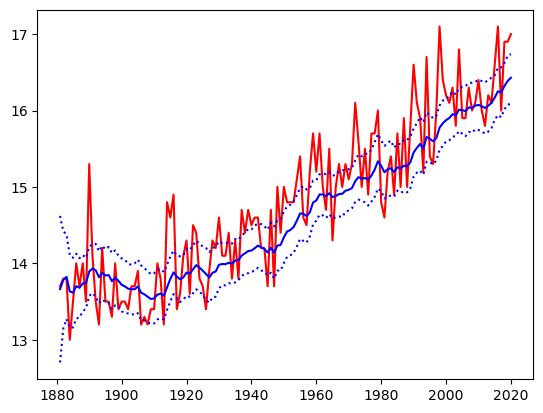

In [5]:
## Plot
plt.plot( td, yobs, color='red' )
plt.plot( td, xest, color='blue' )
plt.plot( td, xuarr, color='blue', linestyle='dotted' )
plt.plot( td, xlarr, color='blue', linestyle='dotted' )
plt.show()